I based this solution on Airplane example from lectures.

In [133]:
import sys
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [134]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

# 1. Constant rate

Passanger deaths number $y_i$ has a Poisson distribution $$y_i\sim\mathrm{Poisson}(\lambda)$$ with a rate $\lambda$ independent on year or miles flown.


### Prior for passanger deaths rate
Assuming that having fatal accident every day (as in lecture). We can consider 130 passengers per flight - number of seats in original Boeing 737 - 100/200 (they were introduced in early 70's, so its probable number of passengers on flight in given period). It likely that all passangers will die in accident, so upper limit will be 47450
$$\lambda+3\sqrt{\lambda}\approx47450$$

In [135]:
root_of_lam=np.polynomial.polynomial.polyroots([-47450.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)



[46801.]


#### Prior tuning in Stan
Iused method and model described in lecture - finding $\sigma$ for a HalfNormal distribution. I also tried using Poisson distribution (task1_priortune_poisson.stan) but it failed.

In [136]:
with open('task1_priortune.stan', 'r') as file:
    print(file.read())
tuning=stan_utility.compile_model('task1_priortune.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd734af351cd9cf4c70d3f81e2f0dd9d NOW.


functions {
  // Difference between one-sided Gaussian tail probability and target probability
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess; // Initial guess of Gaussian standard deviation
  vector[1] theta;       // Target quantile
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i, 1e-10, 1e-4, 1e6);

  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}



In [137]:
data=dict(y_guess=np.array([int(np.log(20000))]),theta=np.array(lam_ub))
tuned = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = np.round(tuned2.extract()['sigma'][0])
print(sigma)

18169.0


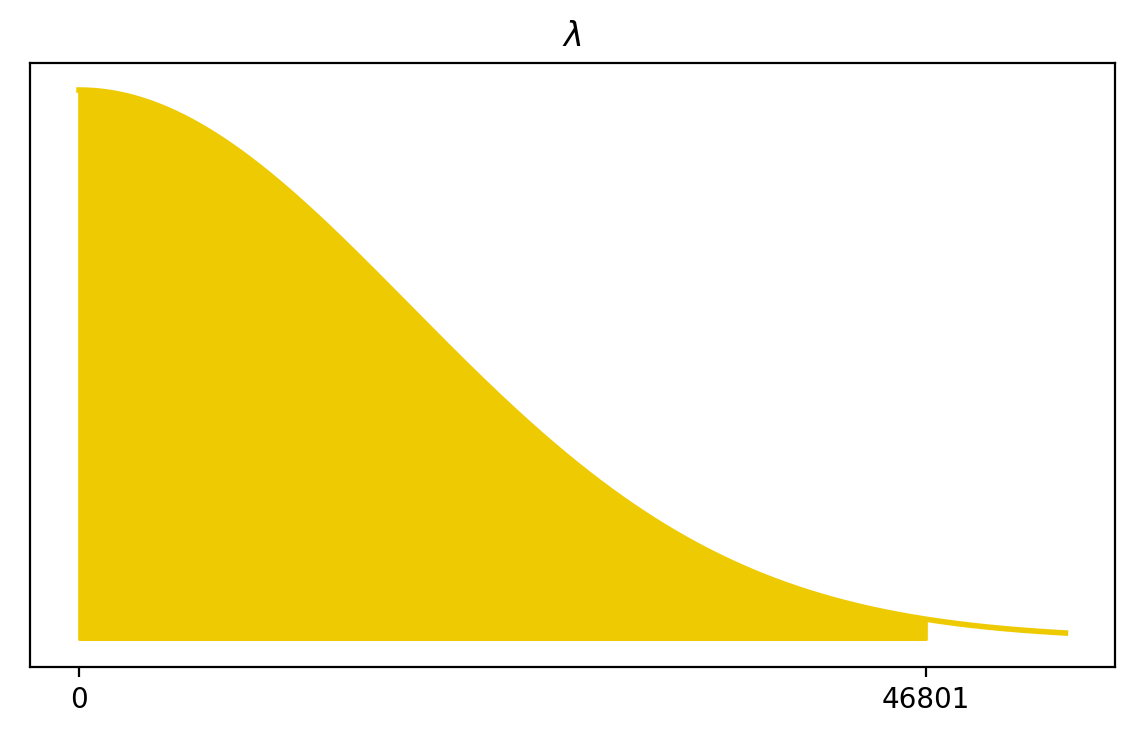

In [138]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

### Prior predictive distribution

In [139]:
with open('task1_prior_model.stan', 'r') as file:
    print(file.read())
model_prior=stan_utility.compile_model('task1_prior_model.stan')

data {
  int M;//number of years analyzed
}


generated quantities {
  real lambda=fabs(normal_rng(0,18169));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}

Using cached StanModel


In [140]:
R=1000
sim_uf=model_prior.sampling(data={'M':1},
                            algorithm="Fixed_param",
                            iter=R,
                            warmup=0,
                            chains=1, 
                            refresh=R,
                            seed=29042020)

[734, 516, 754, 877, 814, 362, 764, 809, 223, 1066] [-0.01 -0.02 -0.03 -0.04 -0.05 -0.06 -0.07 -0.08 -0.09 -0.1 ]


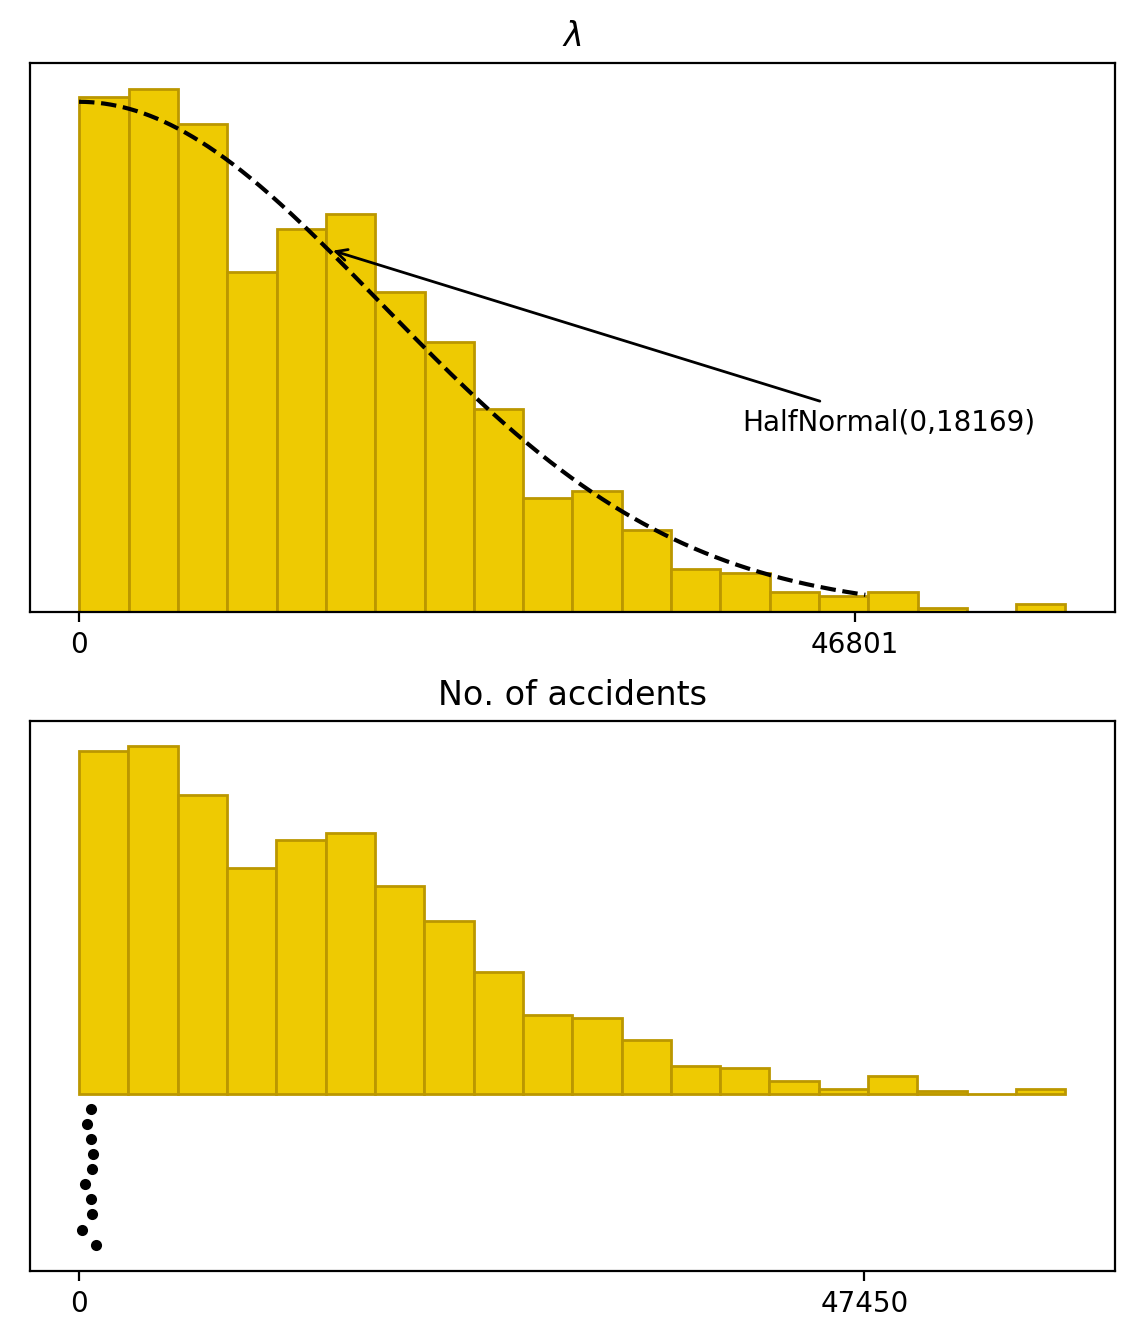

In [141]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,47450,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(15000,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(15000,arr_y_loc),xytext=(40000,0.5*arr_y_loc),arrowprops={'arrowstyle':'->'})

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Passenger deaths']:  
    dta_cnt.append(-(1.+len(acc))/100)
    acc.append(k)
dta_cnt=np.array(dta_cnt)
print(acc, dta_cnt)

Airline_data

ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.0002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,47450])
ax2.set_yticks([])
ax2.set_title('No. of accidents')

plt.show()

## Posterior inference and posterior predictive checks

In [142]:
with open('task1_post_tune.stan', 'r') as file:
    print(file.read())
model=stan_utility.compile_model('task1_post_tune.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1eb37d953b94a43b369407df51c3a537 NOW.


data {
  int M;//number of years analyzed
  int y[M];//number of deaths
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,18169);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [143]:
data = dict(M = len(Airline_data),
            y = Airline_data['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']


In [144]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [145]:
print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 691.59
89% confidence interval: [ 677.91 704.62 ]


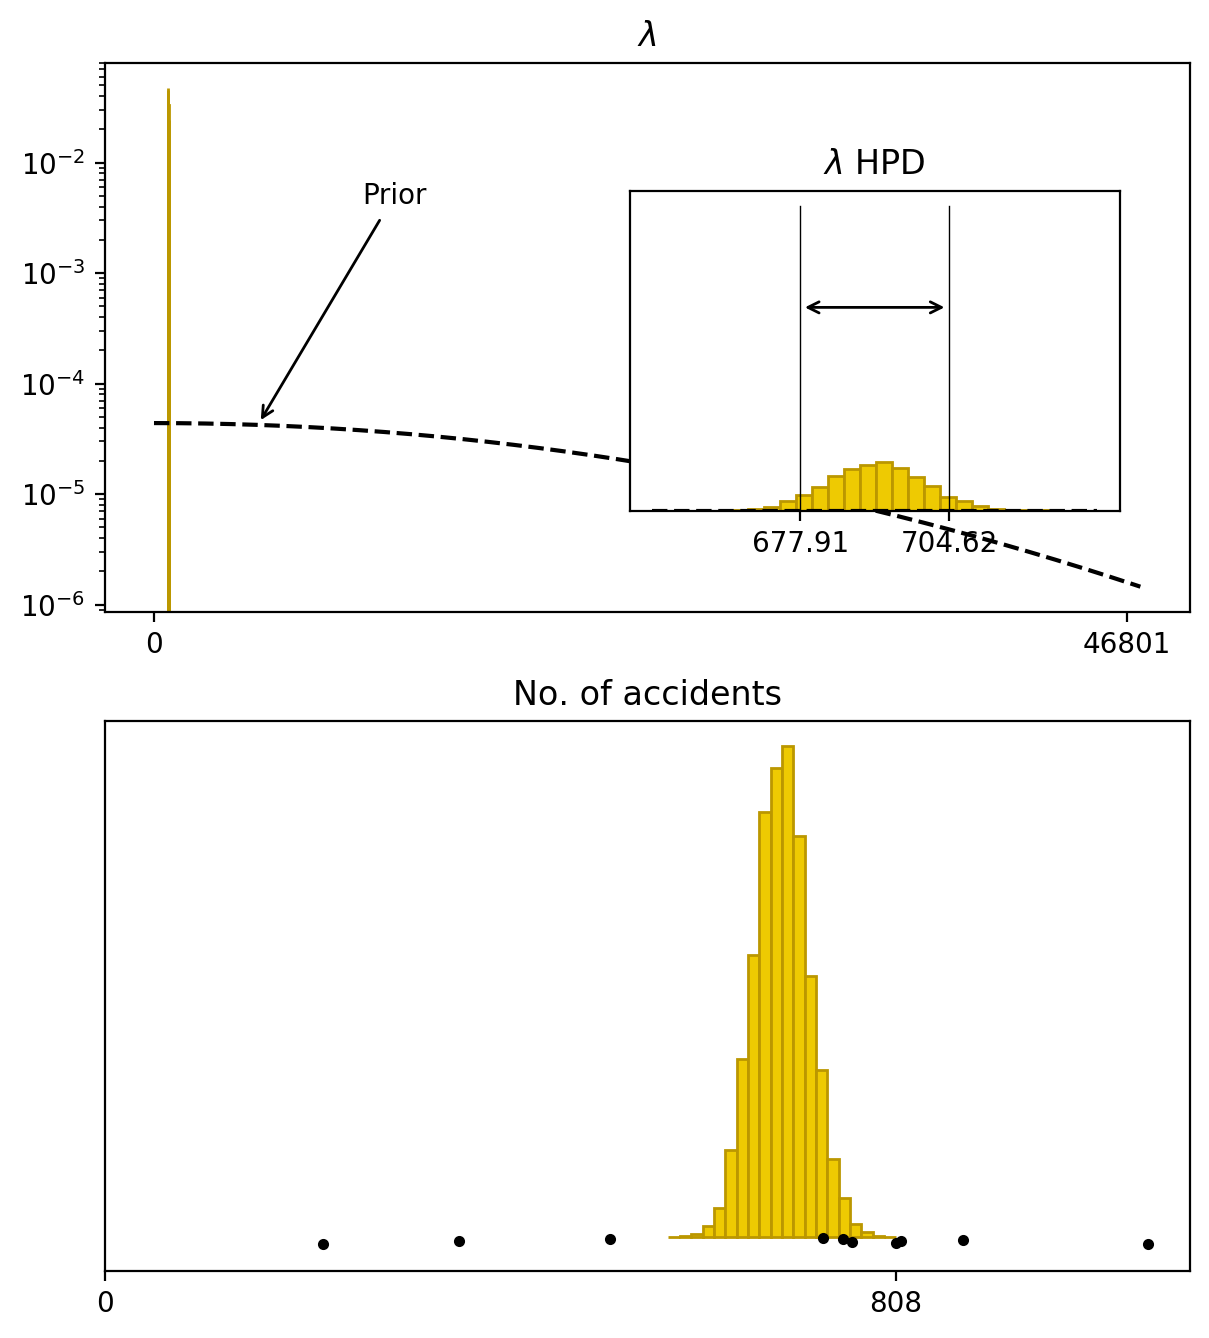

In [146]:
fig, axes = plt.subplots(2, 1,figsize=(7, 8))
ax1=axes[0]
ax1.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,47450,1000)

ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(5000,0,sigma)
ax1.annotate('Prior',xy=(5000,arr_y_loc),xytext=(10000,100*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0,lam_ub[0]])

ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.set_yscale('log')

ax_sm=plt.axes([0.5,0.6,0.35,0.2])
x_sm=np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0]-.2,0.2), xytext=(cinf_lam[1]+.2,0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0],cinf_lam[0]],[0,0.3],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_lam[1],cinf_lam[1]],[0,0.3],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0],cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2=axes[1]
ax2.hist(y_sim.flatten(),color=dark,edgecolor=dark_highlight,density=True,bins=20,zorder=1)
ax2.scatter(acc,0.002*dta_cnt,color='black',marker='.',zorder=2)
ax2.set_xticks([0,np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of accidents')
plt.show()

Data of deaths is quite scattered and genereted model doesn't fit all of them.

### Using model for prediction

In 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown.

In [147]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 691.0
Confidence interval = [ 648.0 735.0 ]


Although result seems possible it misses real value. Additionally it doesn't fit in confidence interval - it is probably too narrow. 

# 2. Constant intensity, rate is a product of intensity and miles flown

As in lecture I will can decompose rate $\lambda$ into intensity $\theta$ and exposure $n$, i.e.

$$y_i\sim\mathrm{Poisson}(\theta n)$$
With $n$ being a number miles flown (in 100 mil)

### Prior for passanger deaths rate
I will also use assumptions disccuesed earlier (1 accident per day and 130 passanger per flight), so upper limit will be equal 47450.

$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx47450$$

In [148]:
mean_miles=np.mean(Airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-47450./mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 8.188


In [149]:
data=dict(y_guess=np.array([np.log(5)]),theta=np.array(theta_ub))
tuned = tuning.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 3.179


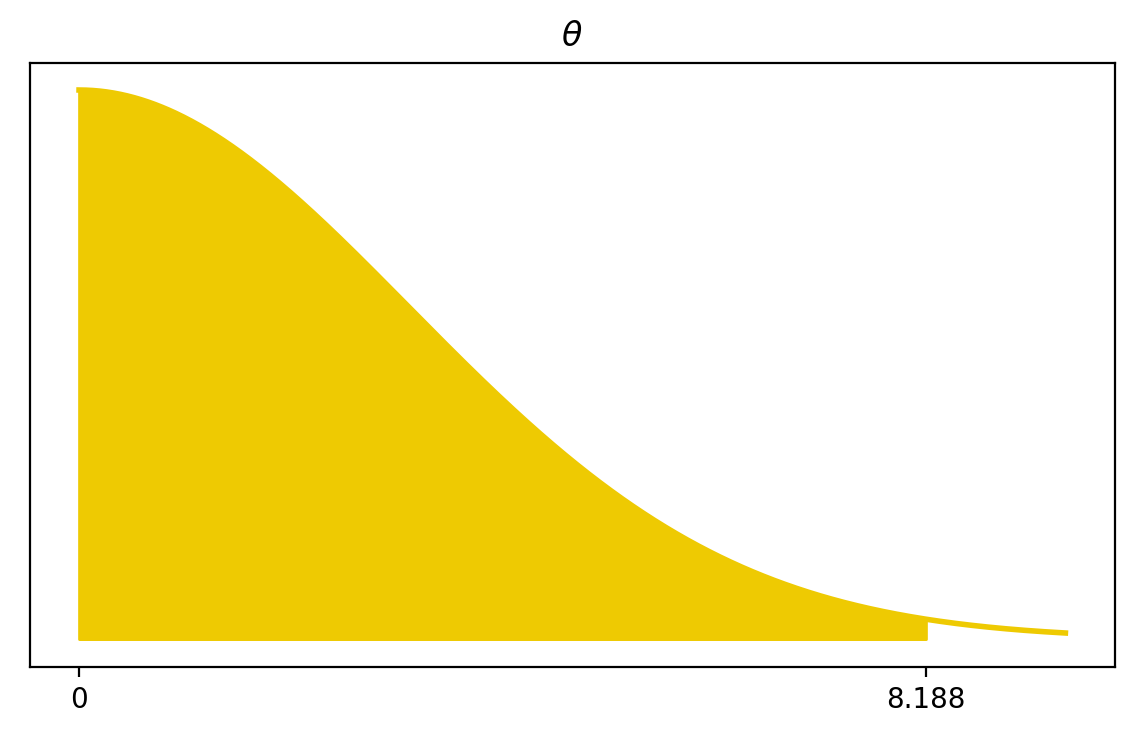

In [150]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x2,2*stats.norm.pdf(x2,scale=sigma),color=dark,linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_xticklabels([0,8.188])
ax2.set_title(r'$\theta$')
plt.show()

### Prior predictive distribution
We can use stan to simulate possible outputs and parameteres based only on prior information.

In [151]:
with open('task2_prior_model.stan', 'r') as file:
    print(file.read())
model_prior=stan_utility.compile_model('task2_prior_model.stan')

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
}


generated quantities {
  real theta=fabs(normal_rng(0,3.179));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}

Using cached StanModel


In [152]:
R=1000
data_prior=dict(M=len(Airline_data),miles=Airline_data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R,
                     seed=29042020)

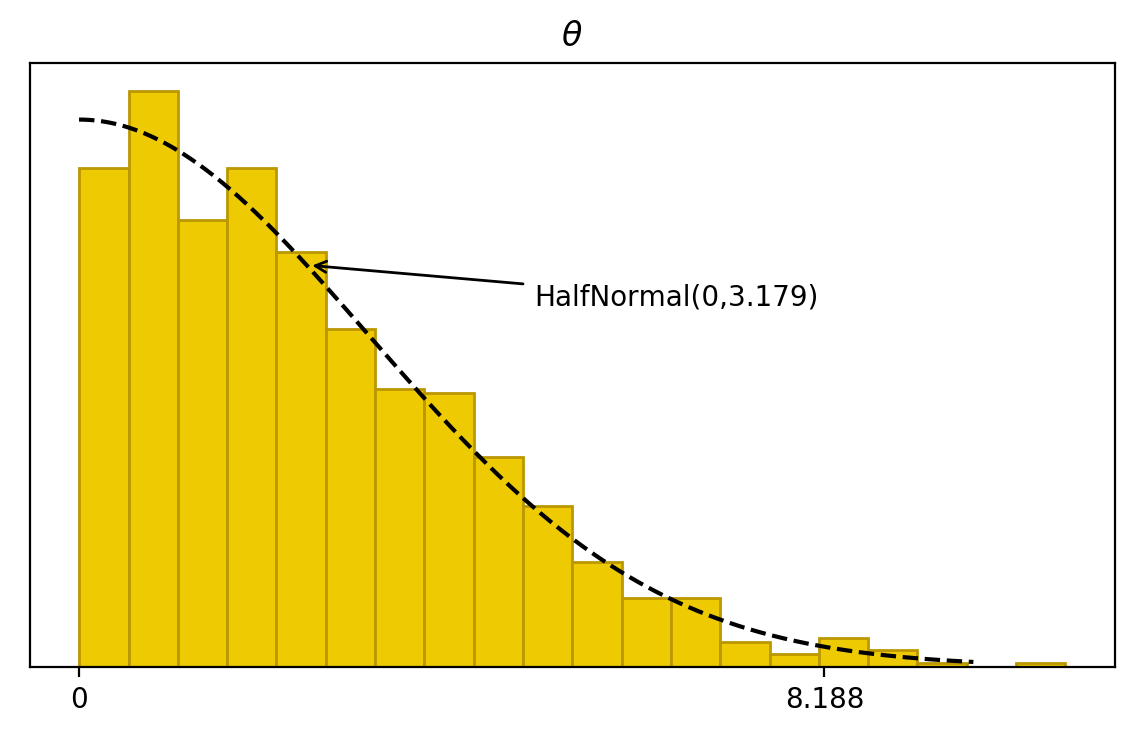

In [153]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(2.5,0,sigma)
ax1.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(2.5,arr_y_loc),xytext=(5,0.9*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

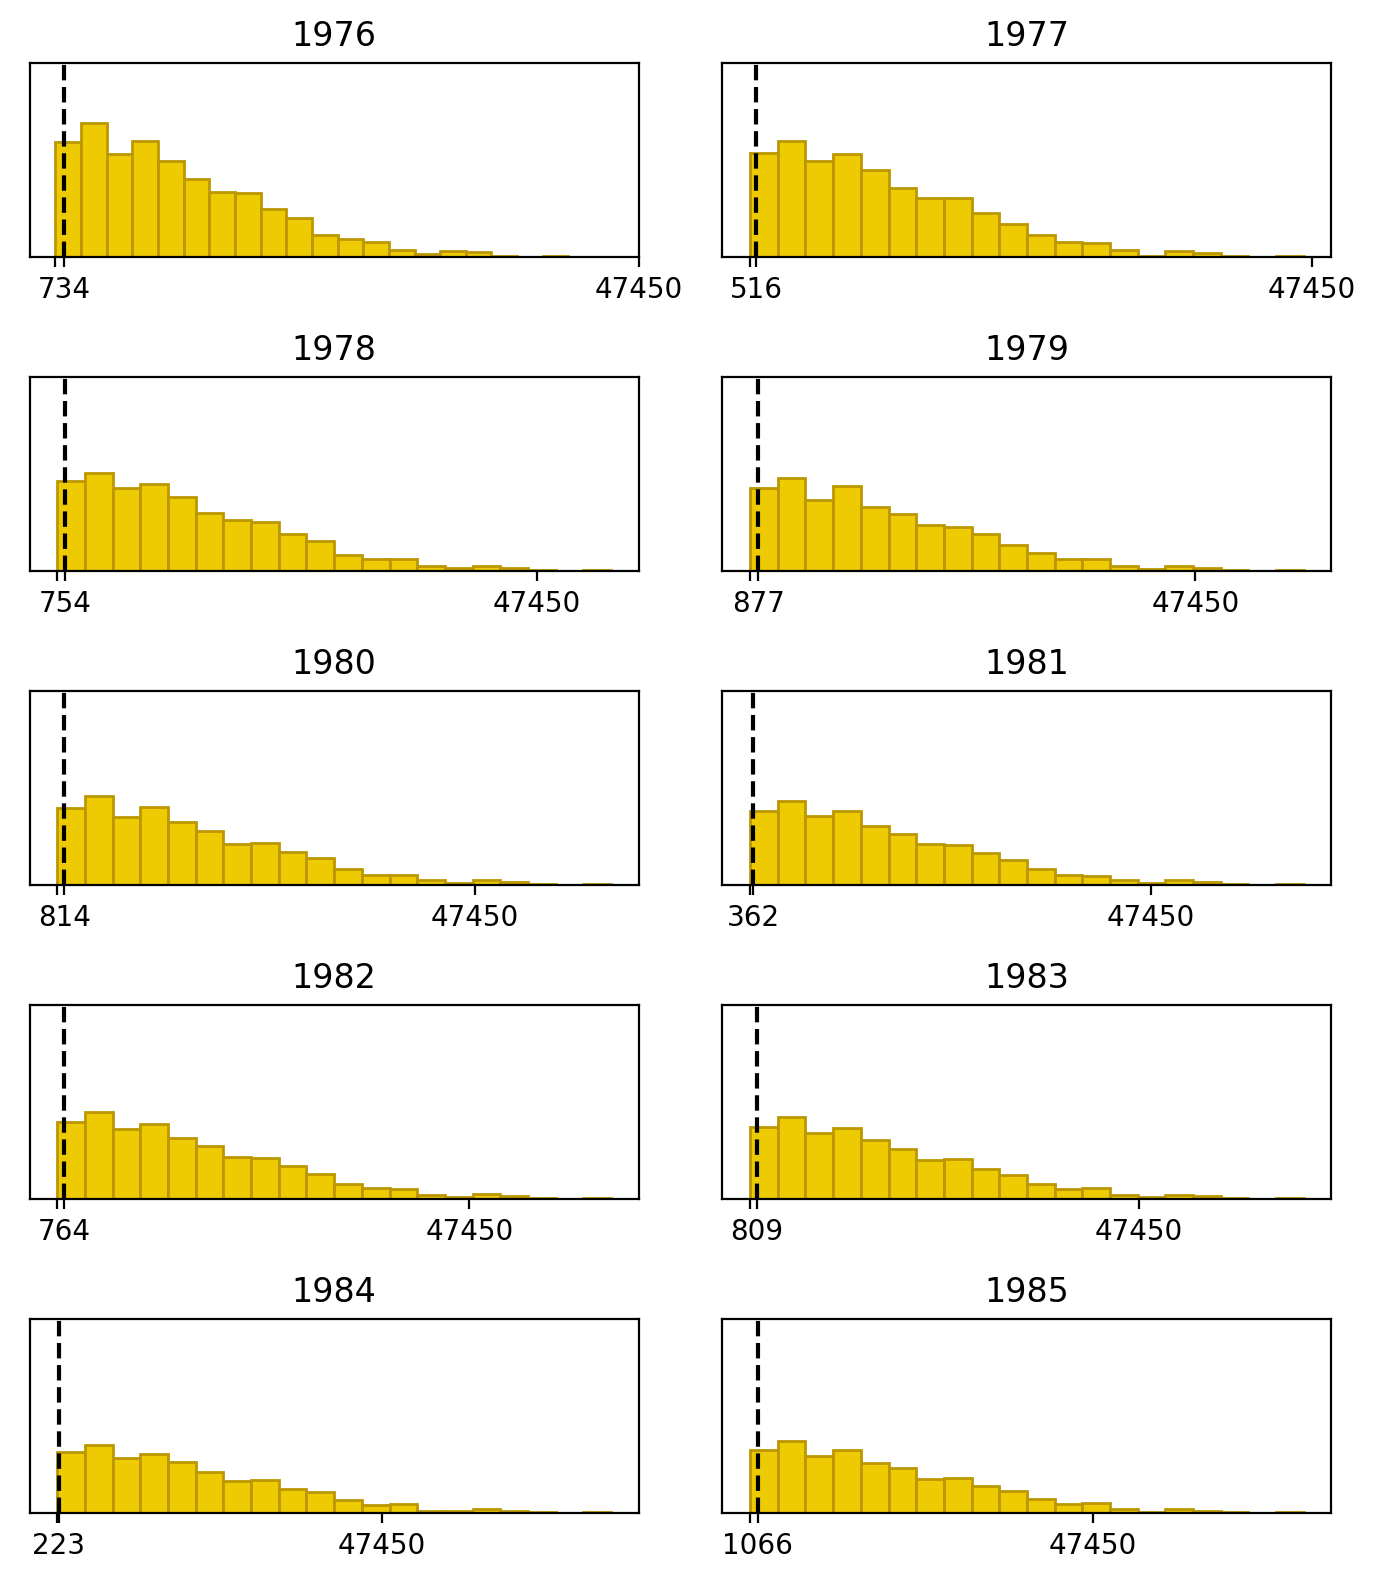

In [154]:
y_sim=params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.02],linestyle='--',color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,47450])
    ax.set_xticklabels(['',tv,47450])
    ax.set_ylim([0,0.0001])

fig.tight_layout()

plt.show()

## Posterior inference and posterior predictive checks

In [155]:
with open('task2_post_tune.stan', 'r') as file:
    print(file.read())
model_miles=stan_utility.compile_model('task2_post_tune.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43d07e233fd031a842730ebb2cc0ae90 NOW.


data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of deaths
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,3.179);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k]*theta);
  }
}



In [156]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit = model_miles.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']


In [157]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]

In [158]:
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1211
89% confidence interval: [ 0.1189 0.1235 ]


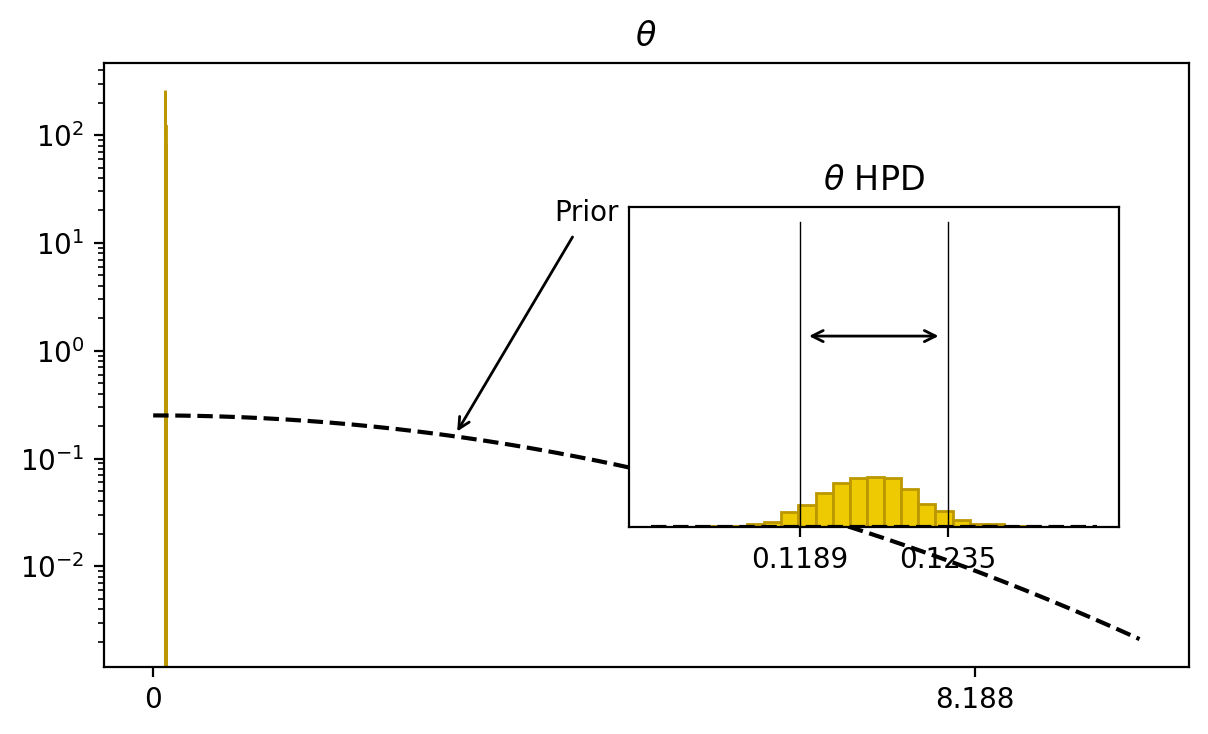

In [159]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,np.round(theta_ub[0],3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(3,0,sigma)
ax1.annotate('Prior',xy=(3,arr_y_loc),xytext=(4,100*arr_y_loc),arrowprops={'arrowstyle':'->'})
ax1.set_yscale('log')

ax_sm=plt.axes([0.5,0.3,0.35,0.4])
x_sm=np.linspace(cinf_theta[0]-hpd_width,cinf_theta[1]+hpd_width,200)
ax_sm.hist(theta,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax_sm.plot(x_sm,2*stats.norm.pdf(x_sm,0,sigma),color='black',linestyle='--')
ax_sm.annotate(s='', xy=(1.001*cinf_theta[0],1000), xytext=(0.999*cinf_theta[1],1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0],cinf_theta[0]],[0,1600],color='black',linestyle='-',linewidth=0.5)
ax_sm.plot([cinf_theta[1],cinf_theta[1]],[0,1600],color='black',linestyle='-',linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0],cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0],cinf_theta[1]],4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

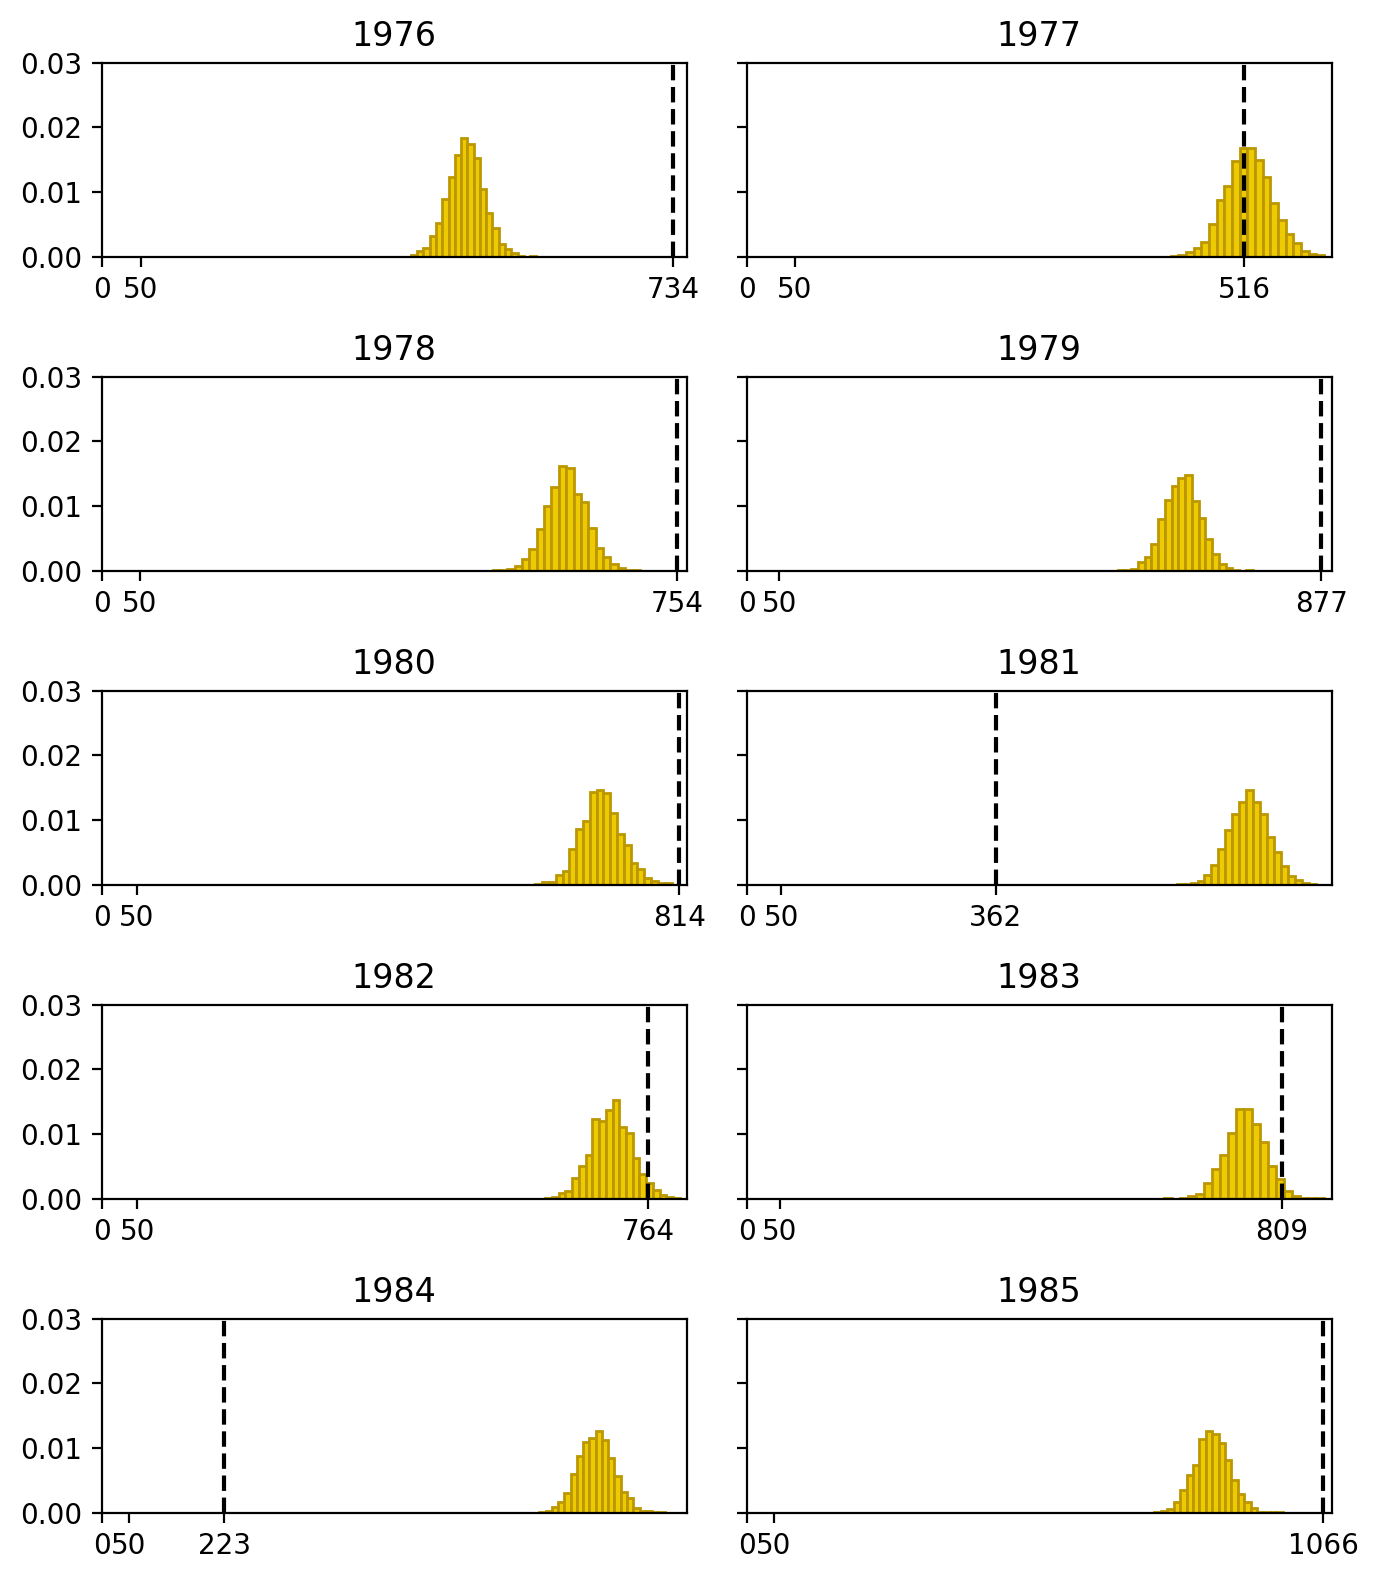

In [160]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=20,color=dark,edgecolor=dark_highlight,density=True)
    ax.set_title(Airline_data.index[k])
    tv=Airline_data['Passenger deaths'].iloc[k]
    ax.plot([tv,tv],[0,0.15],linestyle='--',color='black')
    ax.set_xticks([0,tv,50])
    ax.set_xticklabels([0,tv,50])
    ax.set_ylim([0,0.03])

fig.tight_layout()

plt.show()

Predicted model confidence interval is also too narrow. Most real data doesn't fit it.

### Using model for prediction

In this situation prediction might be a slight more complicated, as it requires from us modifying the generated quantities block
As stated before in 1986, there were **22** fatal accidents, **546** passenger deaths, and a death rate of **0.06** per 100 million miles flown. 

In [161]:
miles1986=546/0.06
print(np.round(miles1986))

9100.0


In [162]:
with open('task2_post_model.stan', 'r') as file:
    print(file.read())
model1986=stan_utility.compile_model('task2_post_model.stan')

data {
  int M;//number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M];//number of deaths
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0,3.179);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100*theta);
}

Using cached StanModel


In [163]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)

y_1986=fit1986.extract()['y_1986']

In [164]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')



Median of predicted accidents = 1101.0
Confidence interval = [ 1042.0 1154.0 ]


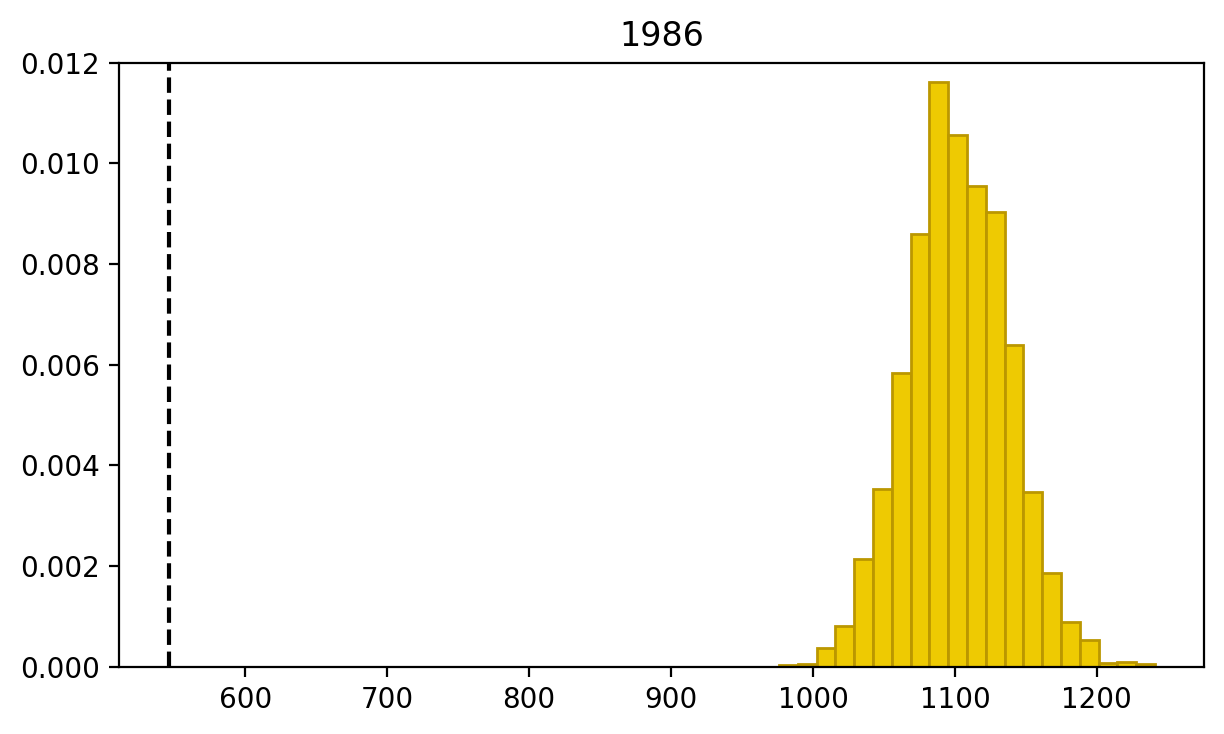

In [167]:
y_sim=params['y_sim']
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1986,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax.set_title('1986')
tv = 546
ax.plot([tv,tv],[0,0.07],linestyle='--',color='black')
ax.set_ylim([0,0.012])


plt.show()

Prediction using this model wasn't really accurate. Real value doesn't fit into confidence interval.